## Mitigatin the Fairness Issues using In-Processing: Reweighting Data

Here we need to use the models that accomodate sample weights. Then we try to give higher weights to the under-represented samples in our senstive group to increase their effect in the optimization process and hopefully learn models that are equalluy accurate for all sensitive groups.


In [11]:
!pip install fairlearn
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover
from sklearn.pipeline import Pipeline
from fairlearn.reductions import DemographicParity, ExponentiatedGradient


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 5.4 MB/s eta 0:00:00a 0:00:01


In [13]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
X = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
X.loc[X['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias

y = pd.DataFrame({'Loan_Approval':np.zeros(X.shape[0])})
y.loc[(X['Sex'] == 0) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
y.loc[(X['Sex'] == 1) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=y['Loan_Approval'], y_pred=y['Loan_Approval'], sensitive_features=X['Sex']
)

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_train = X_train['Sex']
sensitive_test = X_test['Sex']
X_train = X_train.drop(columns=['Sex'])
X_test = X_test.drop(columns=['Sex'])

Here we 1) Calculate the selection rate for each sensitive group in the training set, 2) Inversely proportion the weights to these selection rates.


In [19]:
# Calculate selection rate for each sensitive group
selection_rate_male = y_train[sensitive_train == 0].mean()
selection_rate_female = y_train[sensitive_train == 1].mean()

# Calculate inverse of selection rate
#inverse_rate_male = 1 / selection_rate_male[0] if selection_rate_male[0] > 0 else 1
#inverse_rate_female = 1 / selection_rate_female[0] if selection_rate_female[0] > 0 else 1

inverse_rate_male = 1 / selection_rate_male.iloc[0] if selection_rate_male.iloc[0] > 0 else 1
inverse_rate_female = 1 / selection_rate_female.iloc[0] if selection_rate_female.iloc[0] > 0 else 1

# Normalize the weights to make them sum to the number of samples (keeps the effective size of the dataset unchanged)
normalization_factor = (len(y_train) / (inverse_rate_male * (sensitive_train == 0).sum() + inverse_rate_female * (sensitive_train == 1).sum()))

# Create sample weights based on the sensitive feature
sample_weights = np.ones(len(y_train))
sample_weights[sensitive_train == 0] = inverse_rate_male * normalization_factor
sample_weights[sensitive_train == 1] = inverse_rate_female * normalization_factor


In [27]:
# Train Random Forest classifier with sample weights
clf = RandomForestClassifier(random_state=42)
#clf.fit(X_train, y_train, sample_weight=sample_weights)
clf.fit(X_train, y_train.values.ravel(), sample_weight=sample_weights)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [29]:
# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")


Accuracy: 0.8864087301587301
AUC: 0.9499627976190477


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Sex'>,
        <Axes: xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

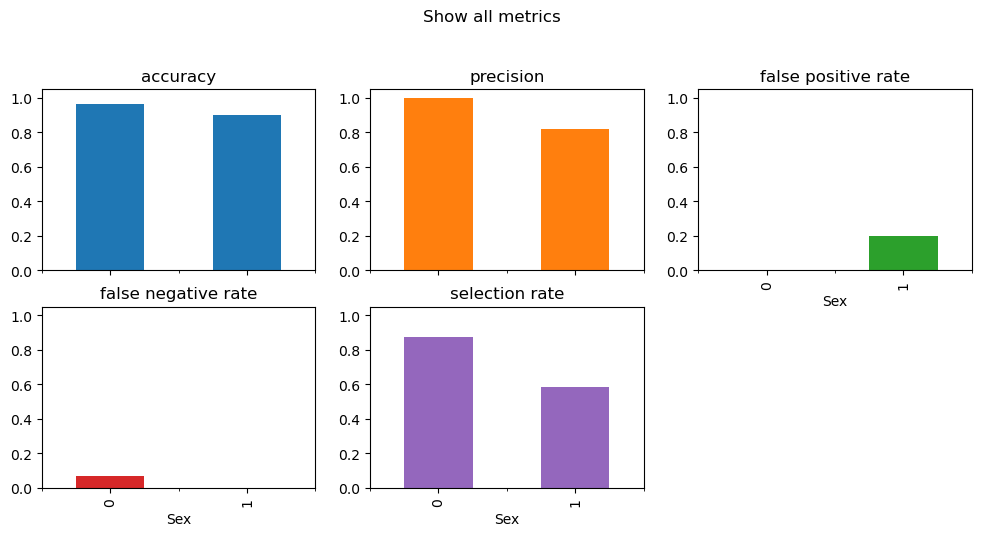

In [31]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)


In [33]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.29166666666666663
Statistical Parity ratio: 0.6666666666666667
Equalized Odds Difference: 0.2
Equalized Odds Ratio: 0.0


**Exercise 4.4:** Try increasing the weight for the femaple group and monitor the change in performance and fairness metrics.

Statistical Parity Difference: 0.2932692307692307
Equalized Odds Difference: 0.16


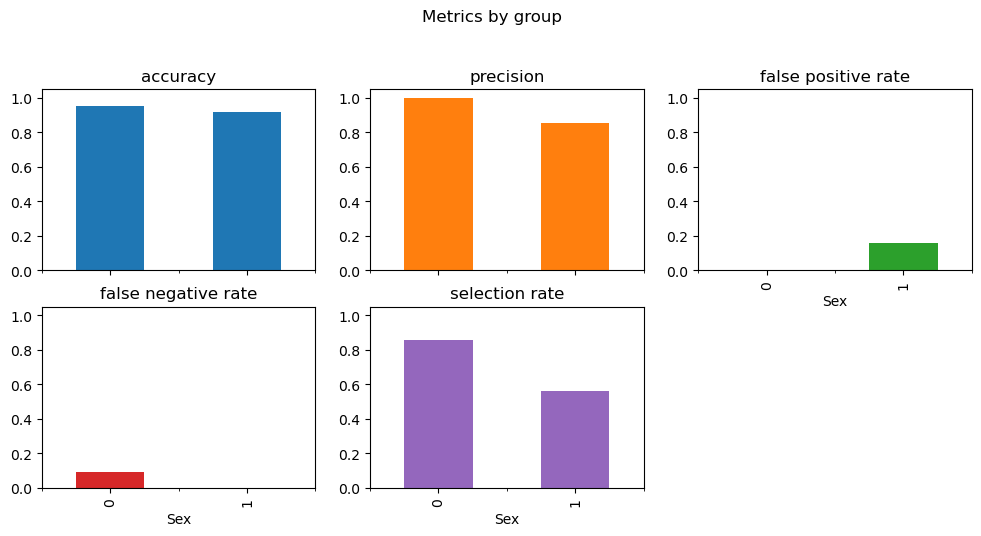

In [39]:
sample_weights[sensitive_train == 1] *= 5  

clf.fit(X_train, y_train.values.ravel(), sample_weight=sample_weights)
y_pred = clf.predict(X_test)

metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test)
metric_frame.by_group.plot.bar(subplots=True, layout=[3, 3], legend=False, figsize=[12, 8], ylim=[0,1.05], title="Metrics by group")

stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")
print(f"Equalized Odds Difference: {equal_odds_diff}")
